In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist

import time


use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device = "cpu"

In [56]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST(root='~/data',download=True, train=True, transform=transform)
testset = datasets.MNIST(root='~/data', download=True, transform=transform)

# Prepare the training set
train_features = torch.cat([data[0].view((1,28*28)) for data in trainset])
train_labels = torch.Tensor([data[1] for data in trainset]).type(torch.long)



In this practical you will learn how to implement supervised variational deep learning methods. The starting point is a multi-class logistic regression on the MNIST dataset.

The forward model is just the linear equation
$$
f(x) = W x
$$
where $W$ is a (number of input pixels)x(number of classes) matrix.
The forward model defines the class probabilities through a softmax transformation, which make the output positive and normalized:
$$
p(y_n = j \mid x_n, W) = \frac{e^{f_j(x)}}{\sum_{k=1}^J e^{f_j(x)}}
$$
This results in the usual softmax cross-entropy negative log likelihood loss. Since we want to approximate the Bayesian posterior, we need to specify a prior over the weights. The simplest choice is a uncorrelated normal distribution:
$$
p(W) = \prod_{j,k} p(W_{jk}) = \prod_{j,k} \mathcal{N}(W_{jk} \mid 0, \nu^2)~.
$$
In order to approximate the posterior, we also need to specify a parameterized variational distribution. The simplest choice is to use another parameterized uncorrelated normal distribution:
$$
q(W; M, S) = \prod_{j,k} q(W_{jk}; M_{jk}, S_{jk}) = \prod_{j,k}\mathcal{N}(W_{jk} \mid M_{jk}, S_{jk}^2)~.
$$
where $M$ and $S$ are arrays of learnable variational parameters. Note that we are assuming that the parameters are uncorrelated under the posterior distribution. This approximation is known as mean-field for historical reasons due to its origin in the analysis of the physics of magnets. As we saw in the lecture, we can train these parameters by minimizing the negative ELBO:
$$
\mathcal{L}(\mu^{(q)}, \sigma^{(q)}) = - \mathbb{E}_{W \sim q(W; M, S)}\left[\log{\frac{\left(\prod_{n=1}^N p(y_n \mid x_n, W) \right) \prod_{j,k} \mathcal{N}(W_{jk} \mid 0, \nu^2)}{\prod_{j,k}\mathcal{N}(W_{jk} \mid M_{jk}, S_{jk}^2)}}\right]
$$
Since we cannot evaluate the loss exactly, we use an unbiased gradient estimator using the reparameterization trick:
$$
\mathcal{L}(\mu^{(q)}, \sigma^{(q)}) \approx -\frac{1}{L} \sum_{m=1}^L \left(\log{\frac{\left(\prod_{n=1}^N p(y_n \mid x_n, M_{jk} + S_{jk} \epsilon^{(m)}_{jk}) \right) \prod_{j,k} \mathcal{N}(M_{jk} + S_{jk} \epsilon^{(m)}_{jk} \mid 0, \nu^2)}{\prod_{j,k}\mathcal{N}(M_{jk} + S_{jk} \epsilon^{(m)}_{jk} \mid M_{jk}, S_{jk}^2)}}\right)
$$
where $E_m$ is a matrix of random numbers sampled from uncorrelated standard normal distributions, a random number for each of the weights (remember, we have a posterior distribution for each entry of the forward model weight matrix).

We are now ready to implement this in pytorch! If you are already familiar with Pytorch, most of the following code will be familiar to you. The only difficulty is that we need to perform some re-shaping gymnastic in order to perform batched operations where both the weights and the input have a batch dimension.
This is required since a batch of weights need to be sampled from the variational posterior at every step in order to compute the Monte Carlo gradient estimator.

We start by defining the variational logistic regression class. Be sure toi study the code (including the comments) in details!

In [57]:
class LinearVariational(nn.Module):
    def __init__(self, in_features, out_features, num_samples, prior_scale):
        super(LinearVariational, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_samples = num_samples

        # prior weights
        self.prior = dist.normal.Normal(loc = torch.zeros(out_features, in_features),
                                 scale = prior_scale*torch.ones(out_features, in_features))
        
        self.mu_W = nn.Parameter(torch.zeros(out_features, in_features))
        self.s_W = nn.Parameter(torch.zeros(out_features, in_features))
    
    def forward(self, x, num_samples):
        sampled = self.sample(num_samples)
        out = torch.matmul(sampled.unsqueeze(0), x.unsqueeze(1).unsqueeze(3)).squeeze()
        return out
        
    def sample(self, num_samples):
        epsilon_dist = dist.normal.Normal(loc = torch.zeros_like(self.mu_W),
                                    scale = torch.ones_like(self.s_W))
        e = epsilon_dist.sample((num_samples,))
        weights = self.mu_W + F.softplus(self.s_W)*e
        return weights
    
class VariationalNetwork(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, num_samples):
        super(VariationalNetwork, self).__init__()
        
        self.fc_1 = nn.Linear(in_features=28*28,
                              out_features=50)
        self.var = LinearVariational(in_features=50,
                                    out_features=10,
                                    num_samples=num_samples,
                                    prior_scale=5.)
        self.out_size = out_size
        self.num_samples = num_samples
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.var(x, self.num_samples)
        return x
    
    def evaluate_log_likelihood(self, features, labels):
        preds = self.forward(features)
        data_batch, param_batch, num_class = preds.shape
        repeated_labels = torch.cat([y.repeat((param_batch,)) for y in labels])
        loss = torch.nn.CrossEntropyLoss(reduction='none')
        log_lk_loss = loss(preds.reshape((data_batch*param_batch, self.out_size)), repeated_labels)
        log_lk_loss = -log_lk_loss.reshape((data_batch, param_batch))
        return torch.mean(torch.sum(log_lk_loss, 0))
    
    def evaluate_ELBO(self, features, labels, correction = 1):
        avg_log_lk = self.evaluate_log_likelihood(features, labels)
        q = dist.normal.Normal(self.var.mu_W, F.softplus(self.var.s_W))
        return correction * avg_log_lk +  torch.mean(dist.kl.kl_divergence(self.var.prior, q))

    def compute_marginalized_predictions(self, features, num_samples):
        pre_preds = self.forward(features)
        preds = nn.Softmax(dim=2)(pre_preds)
        return torch.mean(preds, 1)

        
        
# no minibatching
D = 25
sub_train_features = train_features[:D,:]
sub_train_labels = train_labels[:D]


epochs = 2000
num_samples = 25

vn = VariationalNetwork(in_size=28*28, hidden_size=50, out_size=10, num_samples=num_samples)
optimizer = optim.Adam(vn.parameters(), lr=0.001)

num_params = sum(p.numel() for p in vn.parameters())
print(f"Params: {num_params}")

Params: 15680


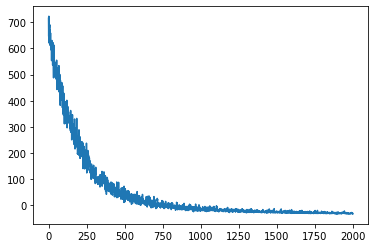

In [58]:
loss_list = []
for epoch in range(epochs):
    optimizer.zero_grad()
    
    loss = -vn.evaluate_ELBO(sub_train_features, sub_train_labels)
    loss.backward()
    optimizer.step()
    
    loss_list.append(float(loss.detach().numpy()))
    
plt.plot(loss_list)
plt.show()

1200.0
epoch 0/10 took 13.9 seconds: 511133.1875
epoch 1/10 took 14.0 seconds: 229905.25
epoch 2/10 took 14.1 seconds: 164637.25
epoch 3/10 took 14.1 seconds: 218027.703125
epoch 4/10 took 14.2 seconds: 124884.0234375
epoch 5/10 took 13.9 seconds: 198108.09375
epoch 6/10 took 13.8 seconds: 203603.984375
epoch 7/10 took 13.8 seconds: 105743.640625
epoch 8/10 took 13.9 seconds: 76346.0
epoch 9/10 took 13.8 seconds: 150871.84375


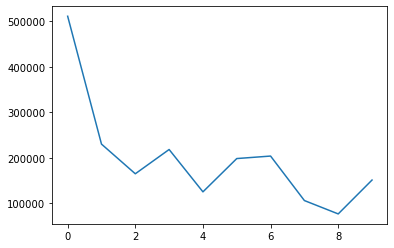

In [59]:
# mini batching
batch_size = 50
epochs = 10
num_samples = 25
vn = VariationalNetwork(in_size=28*28, hidden_size=50, out_size=10, num_samples=num_samples)
vn.to(device)
optimizer = optim.Adam(vn.parameters(), lr=0.001)
data_size = train_features.size()[0]
correction_factor = data_size / batch_size
print(correction_factor)

loss_list = []
for epoch in range(epochs):
    permutation = torch.randperm(data_size)
    start = time.time()
    
    for i in range(0, data_size, batch_size):
        optimizer.zero_grad()
        idxs = permutation[i: i+batch_size]
        sub_train_features = train_features[idxs].to(device)
        sub_train_labels = train_labels[idxs].to(device)
        
        loss = -vn.evaluate_ELBO(sub_train_features, sub_train_labels, correction=correction_factor)
        loss.backward()
        optimizer.step()
        
    loss_list.append(float(loss.detach().numpy()))   
    end = time.time() 
    
    print(f"epoch {epoch}/{epochs} took {str(end - start)[:4]} seconds:", float(loss.detach().numpy()))
        
plt.plot(loss_list)
plt.show()